In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import os
import glob
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import joblib
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [3]:
def load_images_and_labels(image_dir, label_dir):
    images = []
    labels = []

    image_files = sorted(glob.glob(os.path.join(image_dir, '*.jpg')))
    label_files = sorted(glob.glob(os.path.join(label_dir, '*.txt')))

    for image_file, label_file in zip(image_files, label_files):
        image = cv2.imread(image_file)
        image = cv2.resize(image, (256, 256))

        image = cv2.GaussianBlur(image, (5, 5), 0)

        with open(label_file, 'r') as file:
            for line in file:
                class_id, x_center, y_center, width, height = map(float, line.split())
                label = int(class_id)
                images.append(image)
                labels.append(label)

    return np.array(images), np.array(labels)


In [4]:
def extract_hog_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features, _ = hog(gray_image, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True, multichannel=False)
    return features


In [5]:
def augment_data(images, labels):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True
    )

    augmented_images = []
    augmented_labels = []

    for image, label in zip(images, labels):
        image = np.expand_dims(image, 0)
        for augmented_image in datagen.flow(image, batch_size=1):
            augmented_images.append(augmented_image[0])
            augmented_labels.append(label)
            if len(augmented_images) >= len(images) * 2:  # Augment each image twice
                break

    return np.array(augmented_images), np.array(augmented_labels)


In [6]:
train_images, train_labels = load_images_and_labels('/content/drive/My Drive/data_new/train/images', '/content/drive/My Drive/data_new/train/labels')
test_images, test_labels = load_images_and_labels('/content/drive/My Drive/data_new/test/images', '/content/drive/My Drive/data_new/test/labels')

# Augment training data
train_images, train_labels = augment_data(train_images, train_labels)

# Extract HOG features
train_features = np.array([extract_hog_features(image) for image in train_images])
test_features = np.array([extract_hog_features(image) for image in test_images])


<ipython-input-4-6886fb980f83>:3: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features, _ = hog(gray_image, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True, multichannel=False)


In [10]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

# Train the KNN model
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)

# Save the model
joblib.dump(clf, '/content/drive/My Drive/KNN_object_detection.pkl')


['/content/drive/My Drive/KNN_object_detection.pkl']

In [11]:
# Make predictions and calculate accuracy for validation and test sets
val_predictions = clf.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f'Validation Accuracy: {val_accuracy:.2f}')

test_predictions = clf.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Test Accuracy: {test_accuracy:.2f}')


Validation Accuracy: 0.82
Test Accuracy: 0.42


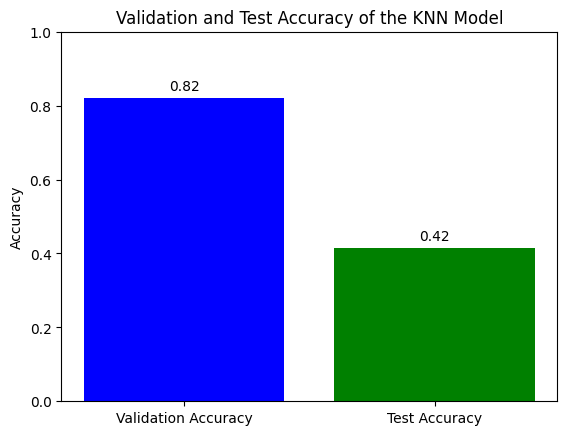

In [12]:
# Plotting the accuracies
labels = ['Validation Accuracy', 'Test Accuracy']
accuracies = [val_accuracy, test_accuracy]

fig, ax = plt.subplots()
bars = ax.bar(labels, accuracies, color=['blue', 'green'])

# Add labels and title
ax.set_ylabel('Accuracy')
ax.set_title('Validation and Test Accuracy of the KNN Model')
ax.set_ylim(0, 1)

# Add text annotations
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Show the plot
plt.show()
